In [77]:
CONFIG_PATH = "configs/debug_small_ID.yml"

In [78]:
from collections import Counter, defaultdict
import os
import random
import shutil
import numpy as np
import pandas as pd
from superdebug import debug
import torch
from data import get_model_input
from utils import get_config, join_sets, load_model, print_log, save_model, load_model_dict
from model import get_best_model
from venn import venn, pseudovenn

##### Preprocess

Load model and data

In [79]:
config = get_config(CONFIG_PATH, "_curation")
target, original_feature_map, categorical_features, string_features, train_data, test_data, test_data_info, num_all_users = get_model_input(config)
model, user_embedding = get_best_model(config, all_feature_columns, feature_names)
active_user_votes_thres = config["active_user_votes_thres"]
train_data["UPVOTED_USERS"] = train_model_input["UPVOTED_USERS"]
train_data["DOWNVOTED_USERS"] = train_model_input["DOWNVOTED_USERS"]
test_data["UPVOTED_USERS"] = test_model_input["UPVOTED_USERS"]
test_data["DOWNVOTED_USERS"] = test_model_input["DOWNVOTED_USERS"]

GPU ready...
Smart using cuda:0
------------------ 2022-07-21 17:25:23 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/data.py:228 get_model_input
Loading prepared data...
------------------ 2022-07-21 17:25:23 ------------------


Collect submissions and active users in different subreddits

In [80]:
def get_subreddits_submissions(train_data, test_data, user_votes_thres = 0):
    subreddit_votes_counter = Counter()
    subreddit_active_users = defaultdict(Counter)
    subreddit_train_submissions = defaultdict(dict)
    subreddit_test_submissions = defaultdict(dict)
    all_submissions = dict()
    for i, row in train_data.iterrows():
        subreddit_votes_counter[row["SUBREDDIT"]] += 1
        subreddit_active_users[row["SUBREDDIT"]][row["USERNAME"]] += 1
        if row["SUBMISSION_ID"] not in subreddit_train_submissions[row["SUBREDDIT"]]:
            subreddit_train_submissions[row["SUBREDDIT"]][row["SUBMISSION_ID"]] = row
            all_submissions[row["SUBMISSION_ID"]] = row
    for subreddit in subreddit_active_users:
        users_vote_count = subreddit_active_users[subreddit]
        subreddit_active_users[subreddit] = {user for user in users_vote_count if users_vote_count[user] >= user_votes_thres}
    for i, row in test_data.iterrows():
        if row["SUBMISSION_ID"] not in subreddit_test_submissions[row["SUBREDDIT"]]:
            subreddit_test_submissions[row["SUBREDDIT"]][row["SUBMISSION_ID"]] = row
            all_submissions[row["SUBMISSION_ID"]] = row
    return subreddit_votes_counter, subreddit_active_users, subreddit_train_submissions, subreddit_test_submissions, all_submissions
subreddit_votes_counter, subreddit_active_users, subreddit_train_submissions, subreddit_test_submissions, all_submissions = get_subreddits_submissions(train_data, test_data, user_votes_thres = active_user_votes_thres) # subreddit_votes_counter, subreddit_users, subreddit_train_submissions are based on train_data, subreddit_test_submissions are based on test_data

Record down existing votes

So that we can use them to substitute the predicted votes

In [81]:
def record_existing_votes(train_data:pd.DataFrame):
    # collect existing votes
    existing_votes = {}
    existing_user_updown_votes = defaultdict(Counter)
    existing_user_votes = Counter()
    existing_submission_votes = defaultdict(Counter)
    for row_i, row in train_data.iterrows():
        existing_votes[f'{row["USERNAME"]}-{row["SUBMISSION_ID"]}'] = row["VOTE"]
        existing_user_updown_votes[row["USERNAME"]][row["VOTE"]] += 1
        existing_user_votes[row["USERNAME"]] += 1
        existing_submission_votes[row["SUBMISSION_ID"]][row["VOTE"]] += 1
    return existing_votes, existing_user_votes, existing_user_updown_votes, existing_submission_votes
existing_votes, existing_user_votes, existing_user_updown_votes, existing_submission_votes = record_existing_votes(train_data)


#### Predict votes for all the users on all submissions

_!!! This process can be time consuming & need more than 200G memory for medium sized dataset, and is not necessary if we use user_embedding to cluster active users_

First convert data to model input

In [82]:
from typing import Union

from tqdm import tqdm
from train import evaluate_model
from model import get_tokenizer

def convert_group_users_subreddit_submissions_data(group_users:Union[set,list], unique_submissions:dict):
    group_users_submissions_data = []
    if type(unique_submissions) == dict:
        unique_submissions = pd.DataFrame(list(unique_submissions.values()))
    if "SUBMISSION_TEXT" in unique_submissions:
        tokenizer = get_tokenizer(config)
        tokenized_submissions_text = tokenizer(list(unique_submissions["SUBMISSION_TEXT"]), padding=True, truncation=True, max_length=512, return_tensors="pt")
        for key in tokenized_submissions_text:
            tokenized_submissions_text[key] = torch.cat([tokenized_submissions_text[key]] * len(group_users), 0)
    else:
        tokenized_submissions_text = None
    for user in tqdm(group_users):
        # for submission_id in unique_submissions:
        #     submission:pd.DataFrame = unique_submissions[submission_id].copy(deep=True)
        #     submission["USERNAME"] = user
        #     group_users_submissions_data.append(submission)
        submissions = unique_submissions.copy(deep=True)
        submissions["USERNAME"] = [user] * len(submissions)
        group_users_submissions_data.append(submissions)

    group_users_submissions_data = pd.concat(group_users_submissions_data,axis=0)
    return group_users_submissions_data, tokenized_submissions_text

all_users = list(range(user_embedding.shape[0]))
all_users_submissions_data, tokenized_all_submissions_text = convert_group_users_subreddit_submissions_data(all_users, all_submissions)


100%|██████████| 15991/15991 [01:19<00:00, 200.14it/s]


Run model to make predictions.

In [83]:
model = model.to(model.device)
# config["batch_size"] = 64
def predict_group_users_submissions_votes(model, group_users_submissions_data, tokenized_submissions_text, feature_names):
    # predict unseen votes
    group_user_submissions_input = {name:group_users_submissions_data[name] for name in feature_names if name in group_users_submissions_data}
    # predict_group_user_submissions_votes = model.predict(group_user_submissions_input, batch_size=config['batch_size'])
    predict_group_user_submissions_votes = evaluate_model(model, group_user_submissions_input, tokenized_submissions_text["input_ids"] if tokenized_submissions_text is not None else None, tokenized_submissions_text["token_type_ids"] if tokenized_submissions_text is not None and "token_type_ids" in tokenized_submissions_text else None, tokenized_submissions_text["attention_mask"] if tokenized_submissions_text is not None else None, np.zeros([len(group_users_submissions_data),1]), data=None, weights = None, batch_size=config["batch_size"], sample_voted_users=False, max_voted_users=max_voted_users, return_prediction = True)
    return predict_group_user_submissions_votes # ndarray size: (3423664, 1)

predicted_all_users_submissions_votes = predict_group_users_submissions_votes(model, all_users_submissions_data, tokenized_all_submissions_text, feature_names)
debug(predicted_all_users_submissions_votes=predicted_all_users_submissions_votes)


MemoryError: Unable to allocate 273. GiB for an array with shape (254112981, 288) and data type int32

In [ ]:
import pickle
pickle.dump(predicted_all_users_submissions_votes, open("output/predicted_all_users_submissions_votes.pt", "wb"))
# predicted_all_users_submissions_votes = pickle.load(open("output/predicted_all_users_submissions_votes.pt", "rb"))


In [ ]:
# model.device = "cuda:0"
def get_group_users_preferred_submissions(model, predicted_group_users_submissions_votes:np.ndarray, group_users, group_users_submissions_data:pd.DataFrame, tokenized_submissions_text:dict, train_data:pd.DataFrame, feature_names, existing_votes, thres = 0.9, existing_pred_submission_user_vote_score_matrix = None):
    debug(max_sub_id = max(group_users_submissions_data["SUBMISSION_ID"]), max_username = max(group_users))
    if existing_pred_submission_user_vote_score_matrix is not None:
        pred_submission_user_vote_score_matrix = existing_pred_submission_user_vote_score_matrix
    else:
        pred_submission_user_vote_score_matrix = - np.ones([max(group_users) + 1, max(group_users_submissions_data["SUBMISSION_ID"]) + 1], dtype = float)
    pred_submission_user_vote_matrix = - np.ones([max(group_users) + 1, max(group_users_submissions_data["SUBMISSION_ID"]) + 1], dtype = int) # use ground truth vote if available, -1 for not in data
    each_submission_votes = {}
    each_user_confidence = defaultdict(list)
    submission_ids = group_users_submissions_data["SUBMISSION_ID"].to_numpy()
    usernames = group_users_submissions_data["USERNAME"].to_numpy()
    for row_i in tqdm(range(len(group_users_submissions_data))):
        submission_id = submission_ids[row_i]
        username = usernames[row_i]
        if existing_pred_submission_user_vote_score_matrix is not None:
            vote_score = existing_pred_submission_user_vote_score_matrix[username, submission_id]
        else:
            vote_score = predicted_group_users_submissions_votes[row_i, 0]
            pred_submission_user_vote_score_matrix[username, submission_id] = vote_score
        if submission_id not in each_submission_votes:
            each_submission_votes[submission_id] = [0, 0]
        each_user_confidence[username].append(abs(vote_score - 0.5))
        if f'{username}-{submission_id}' not in existing_votes:
            vote = int(vote_score >= 0.5)
        else: # use existing votes if available
            vote = existing_votes[f'{username}-{submission_id}']
        pred_submission_user_vote_matrix[username, submission_id] = vote
        each_submission_votes[submission_id][vote] += 1

    # analyze user confidence
    for username in each_user_confidence:
        each_user_confidence[username] = float(np.mean(each_user_confidence[username]))

    # include submissions to preferred_submissions where %upvotes is higher than threshold
    group_preferred_submissions = set()
    for submission_id in each_submission_votes:
        each_submission_votes[submission_id].append(each_submission_votes[submission_id][1] / (each_submission_votes[submission_id][0] + each_submission_votes[submission_id][1])) # %upvotes
        if each_submission_votes[submission_id][-1] >= thres:
            group_preferred_submissions.add(submission_id)

    # sort submissions using %upvotes
    group_submissions_ranking = list(each_submission_votes.keys())
    group_submissions_ranking.sort(reverse=True, key=lambda id: each_submission_votes[id][-1])
    return group_preferred_submissions, group_submissions_ranking, each_submission_votes, each_user_confidence, pred_submission_user_vote_score_matrix, pred_submission_user_vote_matrix

Get prediction score matrix and vote matrix.

We use actual votes to replace predicted votes when available

In [ ]:
if tokenized_all_submissions_text is not None:
    tokenized_all_submissions_text["input_ids"].to(model.device)
    if "token_type_ids" in tokenized_all_submissions_text: tokenized_all_submissions_text["token_type_ids"].to(model.device)
    tokenized_all_submissions_text["attention_mask"].to(model.device)
all_users_preferred_submissions, all_preferred_submissions_ranking, all_submission_votes, all_users_confidence, pred_all_submission_user_vote_score_matrix, pred_all_submission_user_vote_matrix = get_group_users_preferred_submissions(model, predicted_all_users_submissions_votes, all_users, all_users_submissions_data, tokenized_all_submissions_text, train_data, feature_names, existing_votes, thres = config["upvote_downvote_ratio_thres"])


------------------ 2022-07-21 07:09:57 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-28-01a09cb512f6>:3 get_group_users_preferred_submissions
0 / 105.  max_sub_id num val: 696
1 / 106.  max_username num val: 4911
------------------ 2022-07-21 07:09:57 ------------------


100%|██████████| 3423664/3423664 [00:09<00:00, 354616.73it/s]


------------------ 2022-07-21 07:10:08 ------------------
DEBUG: 2 vars: ['pred_all_submission_user_vote_score_matrix', 'pred_all_submission_user_vote_matrix'], at <ipython-input-29-eb8675d17cbe>:7 <module>
0 / 107.  pred_all_submission_user_vote_score_matrix ndarray size: (4912, 697) val: [[1.91129453e-04 4.96307075e-01 4.05929461e-02 ... 4.98095036e-01
  6.63667440e-01 7.08678305e-01]
 [2.33710933e-04 5.17362833e-01 4.52152416e-02 ... 5.19185305e-01
  6.63048804e-01 7.07241595e-01]
 [2.01625880e-04 4.98287827e-01 4.15713377e-02 ... 4.99705970e-01
  6.59908116e-01 7.04591215e-01]
 ...
 [1.43028374e-04 4.88997817e-01 3.62085961e-02 ... 4.91595358e-01
  6.72038853e-01 7.18714535e-01]
 [1.72043510e-04 4.91279542e-01 3.87767404e-02 ... 4.93066072e-01
  6.63476825e-01 7.09108472e-01]
 [1.83798606e-04 4.98157650e-01 4.01435010e-02 ... 5.00195265e-01
  6.66409254e-01 7.11719990e-01]]
1 / 108.  pred_all_submission_user_vote_matrix ndarray size: (4912, 697) val: [[0 0 0 ... 0 1 1]
 [0 1 0 ... 

Calculate Pearson correlation between users

In [ ]:
debug((pred_all_submission_user_vote_matrix==-1).any())
debug(pred_all_submission_user_vote_score_matrix=pred_all_submission_user_vote_score_matrix, pred_all_submission_user_vote_matrix=pred_all_submission_user_vote_matrix)
vote_score_pearson_corr = np.corrcoef(pred_all_submission_user_vote_score_matrix) # (697, 697)
debug(vote_score_pearson_corr=vote_score_pearson_corr)

------------------ 2022-07-21 07:12:12 ------------------
DEBUG: 1 vars: ['?'], at <ipython-input-33-1981fee88399>:1 <module>
0 / 121.  ? numpy.bool_ with val:  False
------------------ 2022-07-21 07:12:12 ------------------
------------------ 2022-07-21 07:12:12 ------------------
DEBUG: 2 vars: ['pred_all_submission_user_vote_score_matrix', 'pred_all_submission_user_vote_matrix'], at <ipython-input-33-1981fee88399>:2 <module>
0 / 122.  pred_all_submission_user_vote_score_matrix ndarray size: (4912, 697) val: [[1.91129453e-04 4.96307075e-01 4.05929461e-02 ... 4.98095036e-01
  6.63667440e-01 7.08678305e-01]
 [2.33710933e-04 5.17362833e-01 4.52152416e-02 ... 5.19185305e-01
  6.63048804e-01 7.07241595e-01]
 [2.01625880e-04 4.98287827e-01 4.15713377e-02 ... 4.99705970e-01
  6.59908116e-01 7.04591215e-01]
 ...
 [1.43028374e-04 4.88997817e-01 3.62085961e-02 ... 4.91595358e-01
  6.72038853e-01 7.18714535e-01]
 [1.72043510e-04 4.91279542e-01 3.87767404e-02 ... 4.93066072e-01
  6.63476825e-01 

#### Perform curation on a subreddit

Select a subreddit from the most popular subreddits

In [ ]:
common_subreddits_counts = subreddit_votes_counter.most_common(20)
for subreddit_id, vote_counts in common_subreddits_counts:
    print(f"Subreddit {subreddit_id}: {original_feature_map['SUBREDDIT'][subreddit_id]}, {vote_counts} votes")
a_subreddit = int(input("Select a subreddit: ")) # common_subreddits_counts[0][0]
print_log(config["log_path"], f"Selected subreddit: {a_subreddit} ({original_feature_map['SUBREDDIT'][a_subreddit]})")
a_subreddit_active_users:set = subreddit_active_users[a_subreddit]
print_log(config["log_path"], f"In train data, subreddit {a_subreddit} have {len(a_subreddit_active_users)} active users (who votes >= {active_user_votes_thres} times), {subreddit_votes_counter[a_subreddit]} votes and {len(subreddit_train_submissions[a_subreddit])} unique submissions. In test data, subreddit {a_subreddit} have {len(subreddit_test_submissions[a_subreddit])} unique submissions.") 

Subreddit 67: r/pics, 3200 votes
Subreddit 84: r/worldnews, 2488 votes
Subreddit 69: r/politics, 1899 votes
Subreddit 60: r/news, 958 votes
Subreddit 50: r/funny, 840 votes
Subreddit 1: r/AskReddit, 742 votes
Subreddit 52: r/gifs, 607 votes
Subreddit 79: r/todayilearned, 567 votes
Subreddit 82: r/videos, 544 votes
Subreddit 51: r/gaming, 394 votes
Subreddit 58: r/movies, 267 votes
Subreddit 43: r/aww, 258 votes
Subreddit 33: r/Showerthoughts, 239 votes
Subreddit 17: r/IAmA, 225 votes
Subreddit 30: r/PublicFreakout, 217 votes
Subreddit 35: r/The_Donald, 212 votes
Subreddit 3: r/BikiniBottomTwitter, 206 votes
Subreddit 10: r/EnoughTrumpSpam, 184 votes
Subreddit 42: r/announcements, 184 votes
Subreddit 77: r/thanosdidnothingwrong, 161 votes
------------------ 2022-07-21 06:57:40 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:115 print_log
Selected subreddit: 69 (r/politics)
------------------ 2022-07-21 06:57:40 ------------------
--------------

In [ ]:
user_grouping_method = config["user_grouping_method"]
# user_grouping_method = "neural"
manual_user_groups = config["manual_user_groups"]
# manual_user_groups = {"Conservative": {66, 39, 10, 44, 16, 60}, "Democratic":{0, 65, 64, 37, 49, 52, 20, 22, 23, 26, 29}}
debug(user_grouping_method=user_grouping_method)


------------------ 2022-07-21 07:27:50 ------------------
DEBUG: 1 vars: ['user_grouping_method'], at <ipython-input-56-dec100cb66ec>:5 <module>
0 / 383.  user_grouping_method str len 6: neural
------------------ 2022-07-21 07:27:50 ------------------


In [ ]:
def get_bool_vec(selected_ids, vec_size):
    bool_vec = torch.zeros([vec_size], dtype = bool)
    for user in selected_ids:
        bool_vec[user] = True
    return bool_vec

def get_user_reps(selected_users, all_user_embedding, train_data:pd.DataFrame = None, selected_submissions = None, method = "neural"):
    assert all_user_embedding is not None
    selected_users_bool_vec = get_bool_vec(selected_users, all_user_embedding.shape[0])
    # user_user_i_map = {}
    selected_user_i_user_map = {}
    user_i = 0
    for user, in_subreddit in enumerate(selected_users_bool_vec):
        if in_subreddit:
            # user_user_i_map[user] = user_i
            selected_user_i_user_map[user_i] = user
            user_i += 1
    # assert len(user_user_i_map) == len(user_i_user_map)
    selected_users_reps = None
    if method == "neural":
        selected_users_reps = all_user_embedding[selected_users_bool_vec, :]
    elif method == "votes":
        assert train_data is not None and selected_submissions is not None
        sub_sub_i_map = {sub: sub_i for sub_i, sub in enumerate(list(selected_submissions.keys()))}
        users_reps = torch.zeros([all_user_embedding.shape[0], len(selected_submissions)])
        for row_i, row in train_data.iterrows():
            if row["USERNAME"] in selected_users and row["SUBMISSION_ID"] in selected_submissions:
                vote = 1 if row["VOTE"] == 1 else -1
                users_reps[row["USERNAME"], sub_sub_i_map[row["SUBMISSION_ID"]]] = vote
        selected_users_reps = users_reps[selected_users_bool_vec, :]
        users_vote_sum = (selected_users_reps * selected_users_reps).sum(axis = -1, keepdim= True)
        assert (users_vote_sum != 0).all()
        selected_users_reps = selected_users_reps / users_vote_sum # average votes on each submission
        debug(selected_users_reps = selected_users_reps)

    return selected_users_reps, selected_user_i_user_map


------------------ 2022-07-21 07:28:59 ------------------
DEBUG: 2 vars: ['pred_all_submission_user_vote_score_matrix', 'a_subreddit_active_users_reps'], at <ipython-input-63-cf8b04906e8c>:41 <module>
0 / 416.  pred_all_submission_user_vote_score_matrix ndarray size: (4912, 697) val: [[1.91129453e-04 4.96307075e-01 4.05929461e-02 ... 4.98095036e-01
  6.63667440e-01 7.08678305e-01]
 [2.33710933e-04 5.17362833e-01 4.52152416e-02 ... 5.19185305e-01
  6.63048804e-01 7.07241595e-01]
 [2.01625880e-04 4.98287827e-01 4.15713377e-02 ... 4.99705970e-01
  6.59908116e-01 7.04591215e-01]
 ...
 [1.43028374e-04 4.88997817e-01 3.62085961e-02 ... 4.91595358e-01
  6.72038853e-01 7.18714535e-01]
 [1.72043510e-04 4.91279542e-01 3.87767404e-02 ... 4.93066072e-01
  6.63476825e-01 7.09108472e-01]
 [1.83798606e-04 4.98157650e-01 4.01435010e-02 ... 5.00195265e-01
  6.66409254e-01 7.11719990e-01]]
1 / 417.  a_subreddit_active_users_reps Tensor size: torch.Size([67, 256]) val: tensor([[-0.0055,  0.0021,  0.0044,

##### Obtain representations for active users

User representation will be used to cluster users into groups if `user_grouping_method` is "`neural`" or "`vote`"

Either use this one... (clustering using vote prediction score on submissions in this subreddit, make sure `pred_all_submission_user_vote_score_matrix` is available)

In [ ]:
subreddit_submissions_bool_vec = get_bool_vec(subreddit_test_submissions[a_subreddit].keys(), pred_all_submission_user_vote_score_matrix.shape[1])
a_subreddit_active_users_reps, a_subreddit_active_user_i_user_map = get_user_reps(a_subreddit_active_users, all_user_embedding=pred_all_submission_user_vote_score_matrix[:, subreddit_submissions_bool_vec], train_data=train_data, selected_submissions = subreddit_train_submissions[a_subreddit], method = user_grouping_method)

Or this one... (cluster using user_embedding or sparse actual votes)

In [ ]:
a_subreddit_active_users_reps, a_subreddit_active_user_i_user_map = get_user_reps(a_subreddit_active_users, all_user_embedding=user_embedding, train_data=train_data, selected_submissions = subreddit_train_submissions[a_subreddit], method = user_grouping_method)

##### Cluster active users into multiple groups

In [ ]:
debug(pred_all_submission_user_vote_score_matrix=pred_all_submission_user_vote_score_matrix, a_subreddit_active_users_reps=a_subreddit_active_users_reps)

def get_user_groups(selected_users_reps, selected_user_i_user_map:dict, user_grouping_method = "neural", existing_user_votes=None, manual_user_groups=None):
    group_centers = None
    if user_grouping_method == "single_user_as_group":
        assert existing_user_votes is not None
        users_in_groups = list(selected_user_i_user_map.values())
        users_in_groups.sort(key=lambda x:existing_user_votes[x])
        users_in_groups = users_in_groups[:10] + users_in_groups[-10:]
        users_in_groups = {i: {user} for i,user in enumerate(users_in_groups)}
        # users_in_groups = {i: {user} for i,user in selected_user_i_user_map.items()}
    elif user_grouping_method == "manual":
        users_in_groups = manual_user_groups
    else:
        n_groups = int(len(selected_user_i_user_map) / 10)
        debug(num_selected_users = len(selected_user_i_user_map), n_groups=n_groups) # n_groups: 118
        debug("Begin grouping...")
        from sklearn.cluster import KMeans
        grouping = KMeans(n_clusters = n_groups, random_state = 42, verbose = 0).fit(selected_users_reps)
        group_centers = grouping.cluster_centers_
        """
        from sklearn.cluster import AgglomerativeClustering
        grouping = AgglomerativeClustering(linkage = "complete").fit(selected_users_reps)
        """
        """
        from sklearn.cluster import SpectralClustering
        grouping = SpectralClustering(n_groups, random_state = 42, verbose = 0).fit(selected_users_reps)
        """
        labels = grouping.labels_ # grouping.labels_: [584 350 948 ... 813 938 152]
        """
        from sklearn.mixture import GaussianMixture
        labels = GaussianMixture(n_groups, random_state = 42, verbose = 0).fit_predict(selected_users_reps)
        """
        users_in_groups = defaultdict(set)
        usernames_in_groups = defaultdict(set)
        for user_i, group_x in enumerate(labels): 
            users_in_groups[group_x].add(selected_user_i_user_map[user_i])
            usernames_in_groups[group_x].add(original_feature_map["USERNAME"][selected_user_i_user_map[user_i]])
        assert len(join_sets(users_in_groups.values())) == sum([len(users) for users in users_in_groups.values()])
        debug(group_user_num=str({group_x: len(users_in_groups[group_x]) for group_x in users_in_groups}))
        debug(usernames_in_groups=str(usernames_in_groups))
    return users_in_groups, group_centers

users_in_groups, group_centers = get_user_groups(a_subreddit_active_users_reps, a_subreddit_active_user_i_user_map, user_grouping_method=user_grouping_method, existing_user_votes=existing_user_votes, manual_user_groups=manual_user_groups)

------------------ 2022-07-21 07:29:58 ------------------
DEBUG: 2 vars: ['num_selected_users', 'n_groups'], at <ipython-input-68-0df40922bd6a>:14 get_user_groups
0 / 442.  num_selected_users num val: 67
1 / 443.  n_groups num val: 6
------------------ 2022-07-21 07:29:58 ------------------
------------------ 2022-07-21 07:29:58 ------------------
DEBUG: at <ipython-input-68-0df40922bd6a>:15 get_user_groups
Begin grouping...
------------------ 2022-07-21 07:29:58 ------------------
------------------ 2022-07-21 07:29:58 ------------------
DEBUG: 1 vars: ['group_user_num'], at <ipython-input-68-0df40922bd6a>:38 get_user_groups
0 / 444.  group_user_num str len 39: {4: 9, 2: 7, 0: 7, 3: 13, 5: 20, 1: 11}
------------------ 2022-07-21 07:29:58 ------------------
------------------ 2022-07-21 07:29:58 ------------------
DEBUG: 1 vars: ['usernames_in_groups'], at <ipython-input-68-0df40922bd6a>:39 get_user_groups
0 / 445.  usernames_in_groups str len 1081: defaultdict(<class 'set'>, {4: {'bu

##### Predict preferred submissions of each group

And show their relationship using venn

100%|██████████| 16/16 [00:00<00:00, 166.16it/s]


------------------ 2022-07-21 07:29:58 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-28-01a09cb512f6>:3 get_group_users_preferred_submissions
0 / 446.  max_sub_id num val: 686
1 / 447.  max_username num val: 4629
------------------ 2022-07-21 07:29:58 ------------------


100%|██████████| 972/972 [00:00<00:00, 301142.23it/s]


------------------ 2022-07-21 07:29:58 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:115 print_log
Users in group 4 prefers 34/108 submissions (sorted using %upvotes): [514, 682, 302, 515, 394, 562, 480, 527, 577, 355, 651, 627, 588, 487, 676, 321, 330, 595, 348, 637, 332, 281, 500, 470, 612, 160, 133, 162, 625, 296, 395, 568, 439, 285]
------------------ 2022-07-21 07:29:58 ------------------


100%|██████████| 12/12 [00:00<00:00, 167.17it/s]


------------------ 2022-07-21 07:29:58 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-28-01a09cb512f6>:3 get_group_users_preferred_submissions
0 / 448.  max_sub_id num val: 686
1 / 449.  max_username num val: 4805
------------------ 2022-07-21 07:29:58 ------------------


100%|██████████| 756/756 [00:00<00:00, 318554.73it/s]


------------------ 2022-07-21 07:29:58 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:115 print_log
Users in group 2 prefers 34/108 submissions (sorted using %upvotes): [113, 682, 600, 515, 609, 562, 98, 645, 527, 660, 577, 154, 355, 651, 588, 321, 508, 686, 269, 348, 637, 500, 612, 661, 133, 625, 381, 307, 296, 566, 608, 572, 285, 136]
------------------ 2022-07-21 07:29:58 ------------------


100%|██████████| 12/12 [00:00<00:00, 163.22it/s]


------------------ 2022-07-21 07:29:58 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-28-01a09cb512f6>:3 get_group_users_preferred_submissions
0 / 450.  max_sub_id num val: 686
1 / 451.  max_username num val: 4292
------------------ 2022-07-21 07:29:58 ------------------


100%|██████████| 756/756 [00:00<00:00, 304805.71it/s]


------------------ 2022-07-21 07:29:58 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:115 print_log
Users in group 0 prefers 44/108 submissions (sorted using %upvotes): [514, 113, 325, 600, 515, 394, 480, 527, 34, 224, 660, 577, 154, 355, 407, 552, 651, 627, 588, 676, 508, 686, 330, 288, 269, 348, 637, 332, 500, 470, 160, 661, 133, 162, 381, 307, 296, 566, 395, 608, 568, 572, 285, 136]
------------------ 2022-07-21 07:29:58 ------------------


100%|██████████| 22/22 [00:00<00:00, 166.69it/s]


------------------ 2022-07-21 07:29:59 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-28-01a09cb512f6>:3 get_group_users_preferred_submissions
0 / 452.  max_sub_id num val: 686
1 / 453.  max_username num val: 4895
------------------ 2022-07-21 07:29:59 ------------------


100%|██████████| 1404/1404 [00:00<00:00, 327282.99it/s]


------------------ 2022-07-21 07:29:59 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:115 print_log
Users in group 3 prefers 59/108 submissions (sorted using %upvotes): [514, 113, 682, 325, 302, 515, 394, 562, 98, 645, 480, 527, 34, 224, 577, 154, 355, 407, 204, 552, 651, 627, 371, 676, 321, 508, 686, 330, 288, 410, 269, 317, 470, 160, 133, 162, 625, 307, 296, 566, 395, 608, 439, 504, 285, 136, 653, 609, 660, 588, 487, 348, 637, 332, 421, 612, 661, 381, 568]
------------------ 2022-07-21 07:29:59 ------------------


100%|██████████| 34/34 [00:00<00:00, 166.78it/s]


------------------ 2022-07-21 07:29:59 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-28-01a09cb512f6>:3 get_group_users_preferred_submissions
0 / 454.  max_sub_id num val: 686
1 / 455.  max_username num val: 4792
------------------ 2022-07-21 07:29:59 ------------------


100%|██████████| 2160/2160 [00:00<00:00, 330911.56it/s]


------------------ 2022-07-21 07:29:59 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:115 print_log
Users in group 5 prefers 61/108 submissions (sorted using %upvotes): [113, 682, 325, 609, 562, 645, 480, 527, 660, 154, 355, 204, 552, 627, 288, 269, 348, 332, 612, 661, 133, 162, 625, 381, 608, 568, 603, 285, 600, 515, 653, 98, 34, 224, 577, 371, 676, 321, 508, 686, 281, 317, 500, 470, 160, 307, 296, 395, 439, 572, 136, 514, 302, 394, 407, 651, 588, 487, 330, 637, 504]
------------------ 2022-07-21 07:29:59 ------------------


100%|██████████| 19/19 [00:00<00:00, 167.94it/s]


------------------ 2022-07-21 07:29:59 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-28-01a09cb512f6>:3 get_group_users_preferred_submissions
0 / 456.  max_sub_id num val: 686
1 / 457.  max_username num val: 4875
------------------ 2022-07-21 07:29:59 ------------------


100%|██████████| 1188/1188 [00:00<00:00, 323686.71it/s]


------------------ 2022-07-21 07:29:59 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:115 print_log
Users in group 1 prefers 59/108 submissions (sorted using %upvotes): [113, 682, 600, 302, 394, 653, 609, 562, 98, 645, 480, 34, 660, 577, 154, 355, 407, 204, 552, 627, 676, 686, 330, 288, 269, 637, 332, 421, 500, 470, 612, 661, 133, 625, 381, 307, 566, 395, 608, 568, 439, 285, 136, 325, 515, 527, 224, 651, 487, 371, 508, 410, 348, 317, 445, 162, 572, 603, 504]
------------------ 2022-07-21 07:29:59 ------------------


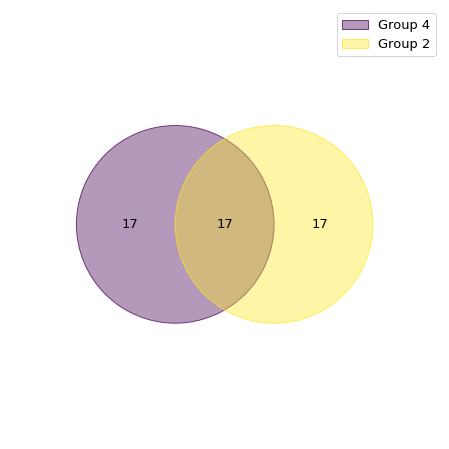

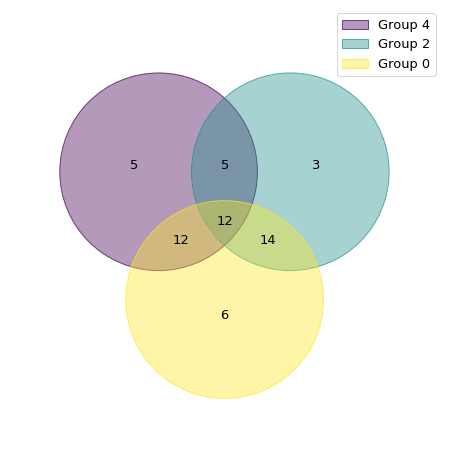

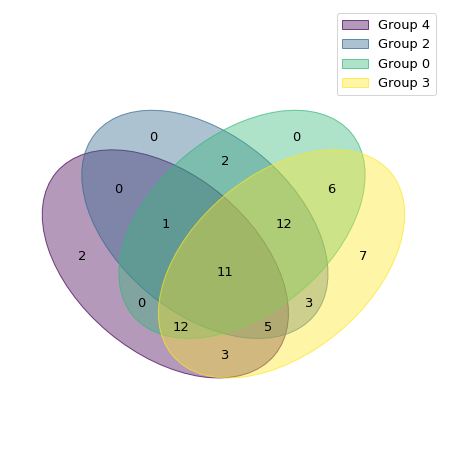

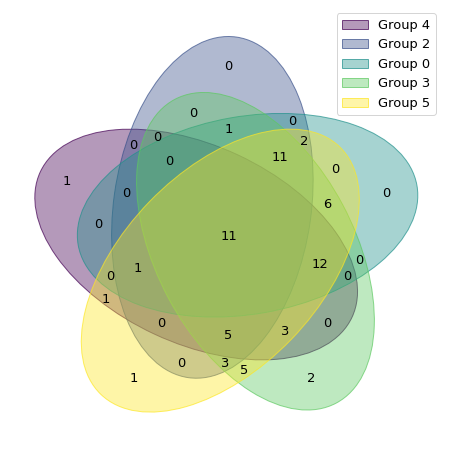

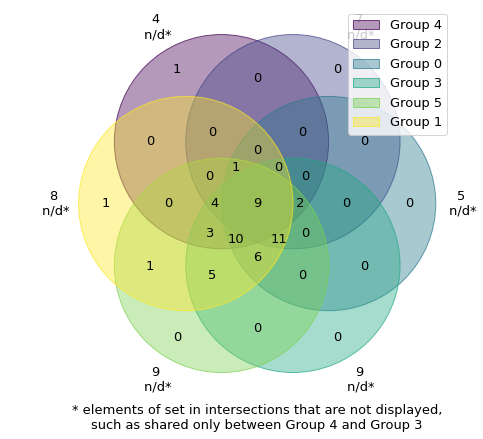

In [ ]:

def predict_groups_preferences(users_in_groups, unique_submissions:dict, train_data, feature_names, group_centers=None, user_grouping_method = "rep", existing_votes = None, existing_user_updown_votes=None):
    # users_in_groups = existing_user_votes.most_common(3)
    groups_users_preferred_submissions = {}
    used_group_centers = []
    if os.path.exists(config["preferred_submissions_venn_figure_dir"]):
        shutil.rmtree(config["preferred_submissions_venn_figure_dir"])
    os.makedirs(config["preferred_submissions_venn_figure_dir"], exist_ok=True)
    for group_x in users_in_groups:
        if (user_grouping_method == "rep") and (len(users_in_groups[group_x]) <= config["group_user_num_lower_thres"] or len(users_in_groups[group_x]) > config["group_user_num_upper_thres"]): # keep middle sized centers
            continue
        if group_centers is not None: # only keep not similar centers
            group_x_center = group_centers[group_x]
            similar_center = False
            for center in used_group_centers:
                if torch.dot(group_x_center, center) > 0:
                    similar_center = True
                    break
            if similar_center:
                continue

        ################ predicting votes of some users and some submissions ##################
        group_x_users_subreddit_submissions_data, tokenized_group_x_users_subreddit_submissions_text = convert_group_users_subreddit_submissions_data(users_in_groups[group_x], unique_submissions)
        predicted_group_x_users_submissions_votes = predict_group_users_submissions_votes(model, group_x_users_subreddit_submissions_data, tokenized_group_x_users_subreddit_submissions_text, feature_names)
        group_x_users_preferred_submissions, group_x_preferred_submissions_ranking, group_x_users_submission_votes, group_x_users_confidence, pred_group_x_users_subreddit_submission_vote_score_matrix, pred_group_x_users_subreddit_submission_vote_matrix = get_group_users_preferred_submissions(model, predicted_group_x_users_submissions_votes, users_in_groups[group_x], group_x_users_subreddit_submissions_data, tokenized_group_x_users_subreddit_submissions_text, train_data, feature_names, existing_votes, thres = config["upvote_downvote_ratio_thres"], existing_pred_submission_user_vote_score_matrix = pred_all_submission_user_vote_score_matrix) # can delete existing_pred_submission_user_vote_score_matrix if not available

        ##########################################################################################

        groups_users_preferred_submissions[f"Group {group_x}"] = group_x_users_preferred_submissions
        if user_grouping_method == "single_user_as_group":
            user_train_vote_prompt = f"voted {existing_user_updown_votes[list(users_in_groups[group_x])[0]]} in training data, prediction confidence {list(group_x_users_confidence.values())[0]}, "
        else:
            user_train_vote_prompt = ""
        print_log(config["log_path"], f"Users in group {group_x} {user_train_vote_prompt}prefers {len(group_x_users_preferred_submissions)}/{len(unique_submissions)} submissions (sorted using %upvotes): {group_x_preferred_submissions_ranking[:len(group_x_users_preferred_submissions)]}")
        if len(groups_users_preferred_submissions) > 1 and len(groups_users_preferred_submissions) <=6:
            ax = venn(groups_users_preferred_submissions) if len(groups_users_preferred_submissions) <=5 else pseudovenn(groups_users_preferred_submissions)
            ax.figure.savefig(f"{config['preferred_submissions_venn_figure_dir']}/{len(groups_users_preferred_submissions)}_groups.png")


model = model.to(model.device)
predict_groups_preferences(users_in_groups, subreddit_test_submissions[a_subreddit], train_data, feature_names, group_centers, user_grouping_method=user_grouping_method, existing_votes=existing_votes, existing_user_updown_votes=existing_user_updown_votes)
